In [1]:
import torch
from torch import optim, nn
from modules.utils import *
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import crop
import torch.nn.functional as F
from torch.utils.data import Subset
from PIL import Image
import modules.model as model
import numpy as np

In [2]:
# Constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training with:", device)

hyper_pars = {'Epochs': 50, 'Factor': 5, 'Noise Type': 'uniform', "Train Size": 512,
                'Noise STD': 0.03, 'Inp. Channel': 16, 'Batch Size': 64,
                'LR': 5e-4, 'Device': device, 'Crop Size': (256, 256), 'Margin': 0.01,
                'Out. Channel': 3, 'Arch.': 32, 'Depth': 4, 'Alpha': 1.0, 'Concat': [1, 1, 1, 1]}
relu = nn.ReLU()

CHECKPOINT_PATH = Path('checkpoint_directory/initial')


Training with: cuda


In [3]:
# Preprocessing images for training and testing
# TBD: Validation set
def crop_hyper(image):
    img_size = (image.shape[1], image.shape[2])
    crop_w, crop_h = hyper_pars['Crop Size']
    top = (img_size[0] - crop_h) // 2
    left = (img_size[1] - crop_w) // 2
    return crop(image, top, left, crop_h, crop_w)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_hyper)
])

data_root = Path("images")

total_size = len(datasets.ImageFolder(root=data_root))
indices = torch.randperm(total_size)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(datasets.ImageFolder(root=data_root, transform=transform), train_indices)
test_dataset = Subset(datasets.ImageFolder(root=data_root, transform=transform), test_indices)

train_loader = DataLoader(train_dataset, batch_size=hyper_pars['Batch Size'], shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=hyper_pars['Batch Size'], shuffle=False, drop_last=False)

for images, labels in train_loader:
    print(f"Batch of images: {images.shape}, Batch of labels: {labels.shape}")
    break

Batch of images: torch.Size([64, 3, 256, 256]), Batch of labels: torch.Size([64])


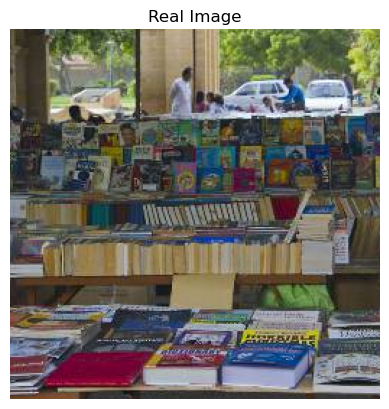

In [5]:
# Printing image from train loader
for images, labels in train_loader:
    image = images[0]

    image_np = image.numpy().transpose((1, 2, 0))
    image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)

    subtitle = ["AI Generated Image", "Real Image"] # Label 0 = AI, Label 1 = Real

    plt.imshow(image_np)
    plt.title(f"{subtitle[labels[0].item()]}")
    plt.axis('off')
    plt.show()
    break

In [4]:
# CNN Model for Denoising
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding,
                                bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers - 2):
            layers.append(
                nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding,
                          bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding,
                                bias=False))
        self.dncnn = nn.Sequential(*layers)

        self._initialize_weights()

        self.prnu = None

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        out = self.dncnn(x)
        return out

    def denoise(self, x):
        x = F.pad(x, (10, 10, 10, 10))
        res = self.dncnn(x)[:, :, 10:-10, 10:-10]

        if res.size()[2] != self.prnu.size()[2] or res.size()[3] != self.prnu.size()[3]:
            return res
        else:
            return res - self.prnu

In [18]:
# Class for training the denoising CNN model (a pretrained one will be used)
class TrainerDnCNN(nn.Module):
    def __init__(self, hyperparams):
        super(TrainerDnCNN, self).__init__()

        self.device = hyperparams['Device']
        self.init_lr = hyperparams['LR']
        self.ch_o = hyperparams['Out. Channel']
        self.m = hyperparams['Margin']
        self.batch_size = hyperparams['Batch Size']
        self.crop_size = hyperparams['Crop Size']
        self.depth = hyperparams['Depth']
        self.crop_b = hyperparams['Crop Batch']

        self.train_loss = []

        self.train_mean_r = []
        self.train_mean_f = []

        self.test_mean_r = []
        self.test_mean_f = []

        self.denoiser = DnCNN(self.ch_o, self.depth).to(self.device)
        self.optimizer = optim.AdamW(self.denoiser.parameters(), lr=self.init_lr)
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, 0.998)

        self.loss_fun = nn.MSELoss(reduction='sum')
        self.loss_bce = nn.BCELoss(reduction='none')


def load_model(trainer, path, device):
    if device.type == 'cpu':
        data_dict = torch.load(path, map_location=torch.device('cpu'))
    else:
        data_dict = torch.load(path)

    try:
        trainer.unet.load_state_dict(data_dict['G state'])
        trainer.train_loss = data_dict['Train G Loss']

        return len(trainer.train_loss)
    except:
        return data_dict

In [6]:
# Loading the denoiser
root = Path("dncnn")

def load_denoiser(device: str, trainable:bool=False):
    denoiser_prnu_np = np.load(str(root / r"clean_real.npy"), allow_pickle=True)
    trainer = load_model(TrainerDnCNN, Path(root / f"chk_2000.pt"), device)
    model = trainer.denoiser.to(device)

    denoiser_prnu = torch.tensor(denoiser_prnu_np.transpose((2, 0, 1))).to(device).unsqueeze(0)
    model.prnu = denoiser_prnu

    if not trainable:
        model.eval()
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True

    return model

In [7]:
# Helper function to calculate distance between two points
def distance(arr, mu_a, mu_b):
    dist_arr2a = np.sqrt(((arr - mu_a) ** 2)).reshape((-1, 1))
    dist_arr2b = np.sqrt(((arr - mu_b) ** 2)).reshape((-1, 1))
    return np.concatenate((dist_arr2a, dist_arr2b), axis=1)

# Helper function to initiate dummy noise model for the first training step
def init_dummy(bs, noise_type, img_dims, ch_n, var=0.1):
    if noise_type == 'uniform':
        img = var * torch.rand((bs, ch_n, img_dims[0], img_dims[1]))
    elif noise_type == 'normal':
        img = var * torch.randn((bs, ch_n, img_dims[0], img_dims[1]))
    elif noise_type == 'mesh':
        assert ch_n == 2
        X, Y = np.meshgrid(np.arange(0, img_dims[1]) / float(img_dims[1] - 1),
                        np.arange(0, img_dims[0]) / float(img_dims[0] - 1))
        meshgrid = np.concatenate([X[None, :], Y[None, :]])
        img = torch.tensor(meshgrid).unsqueeze(0).type(torch.float)

    elif noise_type == 'special':
        X, Y = np.meshgrid(np.arange(0, img_dims[1]) / float(img_dims[1] - 1),
                        np.arange(0, img_dims[0]) / float(img_dims[0] - 1))
        meshgrid = np.concatenate([X[None, :], Y[None, :]])
        img = torch.tensor(meshgrid).unsqueeze(0).type(torch.float)
        img = torch.cat((img, torch.ones((1, 1, img_dims[0], img_dims[1]))), dim=1)
    return img

In [58]:
# Deep Image Fingerprinting model using UNet
class DIFModel(nn.Module):
    def __init__(self, hyperparams):
        super(DIFModel, self).__init__()

        self.device = hyperparams['Device']
        self.init_lr = hyperparams['LR']
        self.ch_i = hyperparams['Inp. Channel']
        self.ch_o = hyperparams['Out. Channel']
        self.arch = hyperparams['Arch.']
        self.depth = hyperparams['Depth']
        self.concat = np.array(hyperparams['Concat'])
        self.m = hyperparams['Margin']
        self.batch_size = hyperparams['Batch Size']
        self.alpha = hyperparams['Alpha']

        self.train_loss = []
        self.train_corr_r = None
        self.train_corr_f = None

        self.test_loss = []
        self.test_corr_r = []
        self.test_corr_f = []
        self.test_labels = []

        self.noise_type = hyperparams['Noise Type']
        self.noise_std = hyperparams['Noise STD']
        self.noise_channel = hyperparams['Inp. Channel']
        self.crop_size = hyperparams['Crop Size']

        d_h, n_h, d_w, n_w = calc_even_size(self.crop_size, self.depth)
        self.crop_size = (n_h - d_h, n_w - d_w)

        self.noise = None
        self.denoiser = load_denoiser(self.device)
        self.unet = model.Unet(self.device, self.ch_i, self.ch_o, self.arch,
                               activ='leak', depth=self.depth, concat=self.concat).to(self.device)
        self.optimizer = optim.AdamW(self.unet.parameters(), lr=self.init_lr)
        self.loss_mse = nn.MSELoss()

        self.init_train()

    def train_step(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)

        self.unet.train()
        self.optimizer.zero_grad()

        residuals = self.denoiser.denoise(images).detach()
        alpha = (1 - self.alpha) * torch.rand((len(images), 1, 1, 1)).to(self.device) + self.alpha
        residuals = alpha * residuals

        f_mean = residuals[~labels].mean(0, keepdims=True)
        r_mean = residuals[labels].mean(0, keepdims=True)
        residuals = torch.cat((residuals, f_mean, r_mean), dim=0)

        dmy = self.prep_noise().to(self.device)
        out = self.unet(dmy).repeat(len(images) + 2, 1, 1, 1)

        corr = self.corr_fun(out, residuals)
        loss = self.loss_contrast(corr[:-2].mean((1, 2, 3)), labels).mean() / self.m

        loss.backward()
        self.optimizer.step()

        if self.fingerprint is None:
            self.fingerprint = out[0:1].detach()
        else:
            self.fingerprint = self.fingerprint * 0.99 + out[0:1].detach() * (1 - 0.99)

        corr = self.corr_fun(self.fingerprint.repeat(len(images), 1, 1, 1), residuals[:-2]).mean((1, 2, 3))

        self.train_loss.append(loss.item())

        if self.train_corr_r is None:
            self.train_corr_r = [corr[labels].mean().item()]
            self.train_corr_f = [corr[~labels].mean().item()]
        else:
            corr_r = corr[labels]
            corr_f = corr[~labels]
            self.train_corr_r.append(corr_r.mean().item())
            self.train_corr_f.append(corr_f.mean().item())

    def test_model(self, test_loader):
        self.reset_tests()
        self.calc_centers()

        fingerprint = self.fingerprint.to(self.device)
        fingerprint.repeat((self.batch_size, 1, 1, 1))

        with torch.no_grad():
            for images, labels in iter(test_loader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                residuals = self.denoiser.denoise(images).float()

                corr = self.corr_fun(fingerprint, residuals)
                loss = self.loss_contrast(corr.mean((1, 2, 3)), labels) / self.m
                mean_corr = corr.mean((1, 2, 3))

                self.test_loss = self.test_loss + loss.tolist()
                self.test_labels = self.test_labels + labels.tolist()
                
                labels = labels.bool()
                
                if self.test_corr_r is None:
                    self.test_corr_r = mean_corr[labels].cpu().numpy()
                    self.test_corr_f = mean_corr[~labels].cpu().numpy()
                else:
                    self.test_corr_r = np.append(self.test_corr_r, mean_corr[labels].cpu().numpy(), axis=0)
                    self.test_corr_f = np.append(self.test_corr_f, mean_corr[~labels].cpu().numpy(), axis=0)

    def predict_image(self, image):
        self.reset_tests()
        self.calc_centers()

        fingerprint = self.fingerprint.to(self.device)
        fingerprint.repeat((self.batch_size, 1, 1, 1))

        with torch.no_grad():
            image = image.to(self.device)
            residual = self.denoiser.denoise(image).float()

            corr = self.corr_fun(fingerprint, residual)
            mean_corr = corr.mean((1, 2, 3))
            dist = distance(mean_corr[0].cpu().numpy(), self.mu_real, self.mu_fake)

            predicted_class = np.argmin(dist, axis=1)

        return predicted_class, dist

    def norm_val(self, arr):
        return (arr - arr.mean((1, 2, 3)).view(-1, 1, 1, 1)) / (arr.std((1, 2, 3)).view(-1, 1, 1, 1) + 1e-8)

    def init_train(self, n=1):
        self.noise = init_dummy(n, self.noise_type, self.crop_size, self.noise_channel)
        self.fingerprint = None

    def prep_noise(self, var=-1):
        if var == -1:
            return self.noise + torch.randn_like(self.noise.detach()) * self.noise_std
        else:
            return self.noise + torch.randn_like(self.noise.detach()) * var

    def corr_fun(self, out, target):
        out = self.norm_val(out)
        target = self.norm_val(target)

        return out * target

    def loss_contrast(self, corrs, labs):
        n = len(corrs) // 2
        corr_a = corrs[:n]
        lab_a = labs[:n]

        corr_b = corrs[n:]
        lab_b = labs[n:]

        sim_label = torch.bitwise_xor(lab_a, lab_b).type(torch.float64)
        corr_delta = torch.sqrt(((corr_a - corr_b) ** 2))
        loss = sim_label * (self.m - corr_delta) + (1. - sim_label) * corr_delta

        return relu(loss)

    def reset_tests(self):
        self.test_corr_r = None
        self.test_corr_f = None

        self.test_loss = []
        self.test_labels = []

    def produce_fingerprint(self):
        with torch.no_grad():
            out = self.fingerprint[0]
            
        return out.cpu().numpy().transpose((1, 2, 0))

    def show_fingerprint(self):
        finger = self.produce_fingerprint()
        finger = 0.5 * finger + 0.5

        plt.figure(figsize=(4, 4))

        plt.imshow(finger)
        plt.axis(False)
        plt.title('Fingerprint')

        plt.show()

        dct_finger = produce_spectrum(finger)
        dct_finger = (dct_finger - dct_finger.min()) / (dct_finger.max() - dct_finger.min())

        plt.figure(figsize=(4, 4))

        plt.imshow(dct_finger, 'bone')
        plt.axis(False)
        plt.title('Fingerprint FFT')

        plt.show()

    def plot_loss(self):
        plt.scatter(np.arange(1, len(self.train_loss) + 1), self.train_loss, s=3, label='Loss', c='g')
        plt.xlabel('Batch Index')
        plt.ylabel('Mean Sample Loss')
        plt.title('Train Loss')

        plt.grid(True)
        plt.ylim([0., 1.0])
        plt.legend(fontsize=12)
        plt.tight_layout()

        plt.show()

    def plot_corr(self):
        plt.scatter(np.arange(len(self.train_corr_r)), self.train_corr_r, s=3,
                    label='Real Corr.', c='g')
        plt.scatter(np.arange(len(self.train_corr_f)), self.train_corr_f, s=3,
                    label='AI Corr.', c='r')
        plt.xlabel('Batch Index')
        plt.ylabel('Mean Sample Corr.')
        plt.title('Train Correlation')

        plt.grid(True)
        plt.legend(fontsize=12)

        plt.show()

    def calc_centers(self):
        self.mu_real = np.mean(self.train_corr_r[-20:])
        self.mu_fake = np.mean(self.train_corr_f[-20:])

    def calc_distance(self):
        dist_real = distance(self.test_corr_r, self.mu_real, self.mu_fake)
        dist_fake = distance(self.test_corr_f, self.mu_real, self.mu_fake)

        return dist_fake, dist_real

    def calc_accuracy(self):
        dist_real = distance(self.test_corr_r, self.mu_real, self.mu_fake)
        dist_fake = distance(self.test_corr_f, self.mu_real, self.mu_fake)

        class_real = np.argmin(dist_real, axis=1) == 1
        class_fake = np.argmin(dist_fake, axis=1) == 0

        acc_real = class_real.sum() / len(class_real)
        acc_fake = class_fake.sum() / len(class_fake)

        return acc_fake, acc_real
        
    def save_stats(self, path):
        self.calc_centers()

        data_dict = {'Fingerprint': self.fingerprint,
                     'Train Real': self.train_corr_r,
                     'Train Fake': self.train_corr_f,
                     'Loss': self.train_loss}

        torch.save(data_dict, path)

    def load_stats(self, path):
        if self.device.type == 'cpu':
            data_dict = torch.load(path, map_location=torch.device('cpu'))
        else:
            data_dict = torch.load(path)

        self.train_loss = data_dict['Loss']
        self.train_corr_r = data_dict['Train Real']
        self.train_corr_f = data_dict['Train Fake']
        self.fingerprint = data_dict['Fingerprint']

In [14]:
# Training the model and saves it to checkpoint directory every 5 epochs
trained_model = DIFModel(hyper_pars).to(hyper_pars['Device'])
epochs = list(range(1, hyper_pars['Epochs'] + 1))

for ep in epochs:
    for residual, labels in train_loader:
        trained_model.train_step(residual, labels)

    if (ep % hyper_pars['Factor']) == 0:
        if ep > 0:
            trained_model.save_stats(CHECKPOINT_PATH / ('chk_' + str(ep) + '.pt'))

    loss = np.mean(trained_model.train_loss[-10:])

    print("Epoch Number:", str(ep), "/", str(len(epochs)), "Loss:", str(loss))

trained_model.save_stats(CHECKPOINT_PATH / ('chk_' + str(hyper_pars['Epochs']) + '.pt'))
torch.cuda.empty_cache()

C:\Users\User\AppData\Local\Temp\ipykernel_10264\3396618432.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(path)


Epoch Number: 1 / 50 Loss: 0.4309798959921407
Epoch Number: 2 / 50 Loss: 0.25379320087918333
Epoch Number: 3 / 50 Loss: 0.18047085148397485
Epoch Number: 4 / 50 Loss: 0.16716370551560078
Epoch Number: 5 / 50 Loss: 0.18297859690942483
Epoch Number: 6 / 50 Loss: 0.20221064459843174
Epoch Number: 7 / 50 Loss: 0.17261944514140345
Epoch Number: 8 / 50 Loss: 0.16073971954246774
Epoch Number: 9 / 50 Loss: 0.1600002531522724
Epoch Number: 10 / 50 Loss: 0.13999477756601647
Epoch Number: 11 / 50 Loss: 0.14334988525890424
Epoch Number: 12 / 50 Loss: 0.1464062940862072
Epoch Number: 13 / 50 Loss: 0.16349081162775714
Epoch Number: 14 / 50 Loss: 0.12079163398876047
Epoch Number: 15 / 50 Loss: 0.13915658167859232
Epoch Number: 16 / 50 Loss: 0.13445959431378246
Epoch Number: 17 / 50 Loss: 0.1194025512613384
Epoch Number: 18 / 50 Loss: 0.10856101827735862
Epoch Number: 19 / 50 Loss: 0.1346299160138587
Epoch Number: 20 / 50 Loss: 0.12235226619172875
Epoch Number: 21 / 50 Loss: 0.09834590965261537
Epoch 

In [59]:
pretrained_epoch = hyper_pars['Epochs']
PRETRAINED_MODEL_FILE_PATH = Path("chk_" + str(pretrained_epoch) + ".pt")
PRETRAINED_MODEL_PATH = CHECKPOINT_PATH.joinpath(PRETRAINED_MODEL_FILE_PATH)
pretrained_model = DIFModel(hyper_pars)
pretrained_model.load_stats(PRETRAINED_MODEL_PATH)

C:\Users\User\AppData\Local\Temp\ipykernel_4296\3396618432.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(path)
C:\Users\User\AppData\Local\Temp

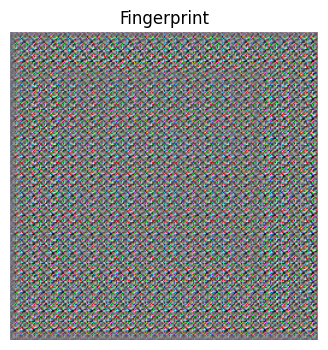

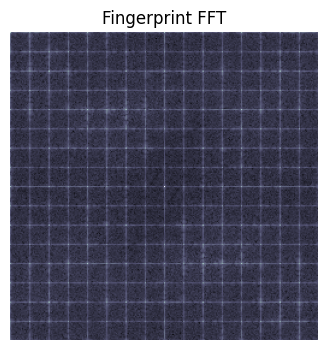

In [60]:
pretrained_model.show_fingerprint()

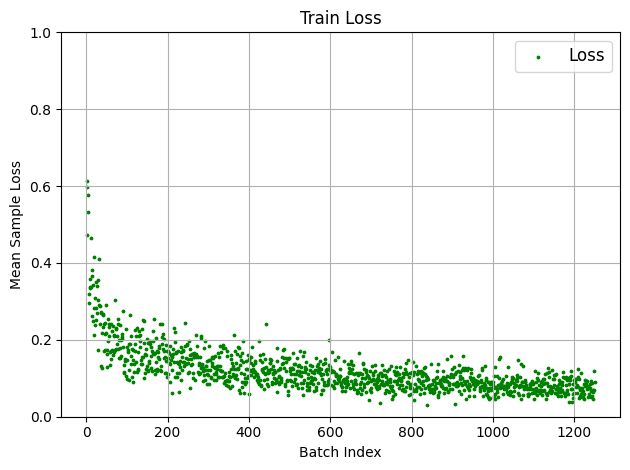

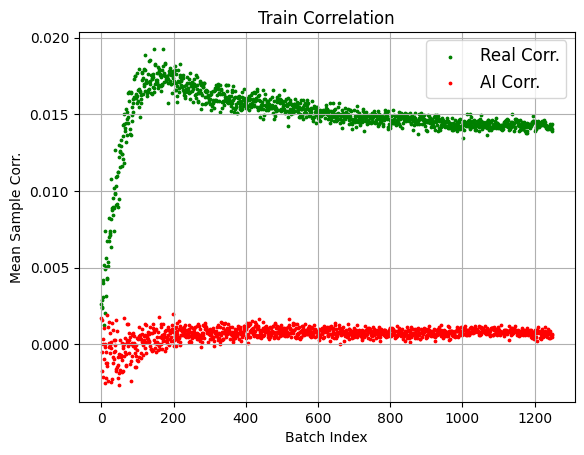

In [61]:
# Loads the model at specific epoch and plots loss and correlation graph
pretrained_model.plot_loss()
pretrained_model.plot_corr()

In [62]:
pretrained_model.test_model(test_loader)
acc_f, acc_r = pretrained_model.calc_accuracy()
acc = (acc_r + acc_f) / 2

print("Real Detection Accuracy:", str(acc_r), "\nAI Detection Accuracy:", str(acc_f), "\nOverall Accuracy:", str(acc))

Real Detection Accuracy: 0.9953703703703703 
AI Detection Accuracy: 0.9945652173913043 
Overall Accuracy: 0.9949677938808373


In [63]:
# Function to predict image based on previously trained model
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(crop_hyper)
    ])

    transform_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256,256))
    ])

    image_tensor = transform_tensor(image)
    image_tensor = image_tensor.unsqueeze(0)
    height = 2
    aspect_ratio = image_tensor.shape[1] / image_tensor.shape[0]
    width = height * aspect_ratio

    plt.figure(figsize=(width, height))
    plt.imshow(image)
    plt.axis('off')

    preprocess_image = preprocess(image)
    preprocess_image = preprocess_image.unsqueeze(0)

    prediction_class, prediction_dist = pretrained_model.predict_image(preprocess_image)
    real_dist = round(prediction_dist[0][1], 4)
    ai_dist = round(prediction_dist[0][0], 4)
    if prediction_class[0] == 1:
        print("Prediction: Real Image", "\nDistance to Real Center:", real_dist, "\nDistance to AI Center:", ai_dist)
    else:
        print("Prediction: AI Generated Image", "\nDistance to Real Center:", real_dist, "\nDistance to AI Center:", ai_dist)

Prediction: Real Image 
Distance to Real Center: 0.0029 
Distance to AI Center: 0.0106


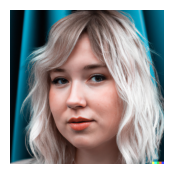

In [64]:
path = "pretrained_examples/"
predict_image(path + 'Dall-E_woman.png') # Wrong Prediction

Prediction: Real Image 
Distance to Real Center: 0.002 
Distance to AI Center: 0.0115


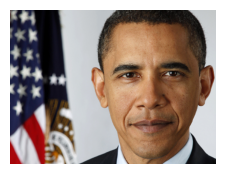

In [65]:
predict_image(path + 'obama.png')

Prediction: Real Image 
Distance to Real Center: 0.0031 
Distance to AI Center: 0.0104


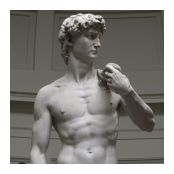

In [66]:
predict_image(path + 'original_0.jpeg')

Prediction: AI Generated Image 
Distance to Real Center: 0.0155 
Distance to AI Center: 0.002


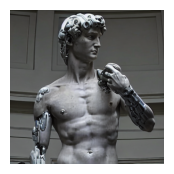

In [67]:
predict_image(path + 'pix2pix_0.png')

Prediction: Real Image 
Distance to Real Center: 0.0062 
Distance to AI Center: 0.0073


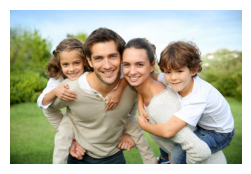

In [68]:
predict_image(path + 'original_1.jpg') # Wrong Prediction

Prediction: AI Generated Image 
Distance to Real Center: 0.0148 
Distance to AI Center: 0.0013


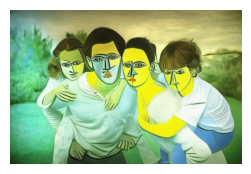

In [69]:
predict_image(path + 'pix2pix_1_default.png')

Prediction: AI Generated Image 
Distance to Real Center: 0.0175 
Distance to AI Center: 0.004


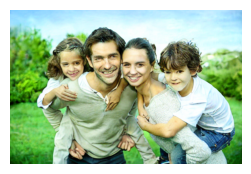

In [70]:
predict_image(path + 'pix2pix_1_image_CFG_3.png')